In [1]:
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from metpy import calc
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
'''calculate temperature C from perturbed potential temperature (K)'''
rp0 = 1.E-5   # p0=100000 的倒数
Rd = 287.04
Cp = 7.*Rd/2.
RCP = Rd/Cp
# Set random seed to ensure reproducible runs
RSEED = 50

wrf=xr.open_dataset('wrfout_d01_2017-05-16_22_00_00')
refdata= xr.open_dataset('grid_ref_200.nc')
zdrfile= xr.open_dataset('grid_zdr_200.nc')
kdpfile= xr.open_dataset('grid_zdp_200.nc')
rhvfile= xr.open_dataset('grid_rhv_200.nc')

zdr=zdrfile['grid_zdr'][1:41,1:501,1:501].values.flatten()  #last no not included
kdp=kdpfile['grid_zdp'][1:41,1:501,1:501].values.flatten()
rhv=rhvfile['grid_rhv'][1:41,1:501,1:501].values.flatten()
ref=refdata['grid_ref'][1:41,1:501,1:501].values.flatten()
print(type(ref))

qv3d=wrf['QVAPOR'][0,:,:,:]
TEMP=wrf['T'][0,:,:,:]
Pres=wrf['P'][0,:,:,:]+wrf['PB'][0,:,:,:]
T= (TEMP + 300.) * ( Pres * rp0 )**RCP #K
print('qv3d coords: {}, \n qv3d attrs: {}'.format(qv3d.coords,qv3d.attrs['units']))
qv3d.attrs['units']='dimensionless'
T.attrs={"units":'K'}
Pres.attrs={"units":'Pa'}
Pres.assign_attrs({"units": 'pressure'})
print(qv3d.attrs['units'],T.attrs,Pres.attrs)
rh=calc.relative_humidity_from_mixing_ratio(qv3d,T,Pres).flatten()
T=T.values.flatten()
P=Pres.values.flatten()
QV=qv3d.values.flatten()*1000.

dataset = pd.DataFrame({'Reflectivity':ref,'ZDR':zdr,'KDP':kdp,'rhv':rhv,'Temp':T,'Pres':P,'RH':rh,'QV':QV})
df=dataset[(dataset['Reflectivity']>15) & (dataset['ZDR']>0.5)]
#df['ZDRCol_Exist']=df['ZDR'].apply(lambda x:int(x>1)) & df['Temp'].apply(lambda x: int(x<273.55))

<class 'numpy.ndarray'>
qv3d coords: Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
    XTIME    datetime64[ns] ..., 
 qv3d attrs: kg kg-1
dimensionless {'units': 'K'} {'units': 'Pa'}


In [48]:
print(type(qv3d))

<class 'xarray.core.dataarray.DataArray'>


In [21]:
df['QV'].describe()

count    169915.000000
mean         10.535849
std           3.785131
min           0.000620
25%           7.386595
50%          11.008563
75%          14.027911
max          17.460688
Name: QV, dtype: float64

In [35]:
df=df.sample(frac=0.3,random_state=100,replace=True)
X=df['Reflectivity,ZDR,KDP,rhv,Temp,Pres'.split(',')]#,ZDRCol_Exist
Y=df[['QV','RH']]

In [63]:
df.columns

Index(['Reflectivity', 'ZDR', 'KDP', 'rhv', 'Temp', 'Pres', 'RH', 'QV'], dtype='object')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state = 42) #, stratify=qv)

In [41]:
rfr=RandomForestRegressor()
rfr.fit(X_train, y_train['QV'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [64]:
rfr.feature_importances_

array([0.04053773, 0.08257573, 0.03914043, 0.02807288, 0.14312648,
       0.66654675])

In [8]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [25]:
import seaborn as sns

In [65]:
feats = {}
for feature, importance in zip(X.columns, rfr.feature_importances_):
    feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(
        columns={0: 'MSE-Importance'})
    importances = importances.sort_values(by='MSE-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})

In [66]:
importances['Features']

0            Pres
1            Temp
2             ZDR
3    Reflectivity
4             KDP
5             rhv
Name: Features, dtype: object

In [13]:
display(importances)

,Features,MSE-Importance
0,Pres,0.350479
1,Temp,0.330413
2,ZDR,0.124178
3,rhv,0.068319
4,Reflectivity,0.066765
5,KDP,0.059845


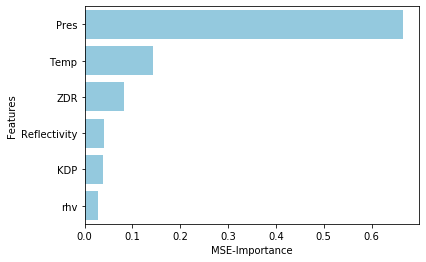

In [67]:
sns.barplot(x=importances['MSE-Importance'], y=importances['Features'], data=importances, color='skyblue')

In [44]:
y_pred = rfr.predict(X_test)
print('the train score is {}'.format(rfr.score(X_train, y_train['QV'])))
print('the predict score is {}'.format(rfr.score(X_test, y_test['QV'])))
y_Ptrain=rfr.predict(X_train)

the train score is 0.9651597200320126
the predict score is 0.8065787784297868


In [50]:
#y_pred.attrs['units']='dimensionless'
X_test['Temp'].attrs={"units":'K'}
X_test['Pres'].attrs={"units":'Pa'}
#X_test['Pres'].assign_attrs({"units": 'pressure'})
y_pre_rh=calc.relative_humidity_from_mixing_ratio(y_pred,X_test['Temp'],X_test['Pres'])

ValueError: `relative_humidity_from_mixing_ratio` given arguments with incorrect units: `temperature` requires "[temperature]" but given "none", `pressure` requires "[pressure]" but given "none".
Any variable `x` can be assigned a unit as follows:
    from metpy.units import units
    x = x * units.meter / units.second

In [27]:
result=pd.DataFrame({'reflectivity':X_test['Reflectivity'],'ZDR':X_test['ZDR'],'KDP':X_test['KDP'],\
                     'rhv':X_test['rhv'],'Temp':X_test['Temp'],'Pres':X_test['Pres'],\
                     'real':y_test,'predict':y_pred,'rh_real':y_test['RH'],'predict_RH':y_pred['RH']})
train=pd.DataFrame({'reflectivity':X_train['Reflectivity'],'ZDR':X_train['ZDR'],'KDP':X_train['KDP'],\
                     'rhv':X_train['rhv'],'Temp':X_train['Temp'],'Pres':X_train['Pres'],\
                     'real':y_train,'predict':y_Ptrain})

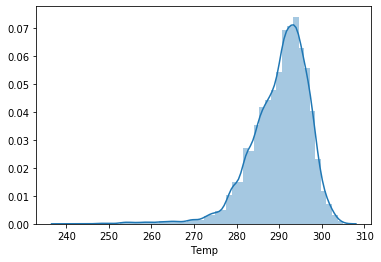

In [137]:
result.corr()
result.describe()
sns.distplot(result['Temp'],kde=True) 

In [61]:
result[(result['real']-result['predict']>2.2) ].describe()

,reflectivity,ZDR,KDP,rhv,Temp,Pres,real,predict
count,10195.000000,10195.000000,10195.000000,10195.000000,10195.000000,10195.000000,10195.000000,10195.000000
mean,32.521027,2.558275,4.137724,0.989731,290.100952,81282.031250,10.538874,10.520427
std,9.538361,0.870912,1.886891,0.013548,6.512735,8667.411133,3.780643,3.410779
min,15.010368,0.500271,1.289461,0.846470,246.597519,35279.832031,0.004316,0.192845
25%,24.867042,1.850338,2.616610,0.993942,286.461395,75138.621094,7.375329,7.541247
50%,32.758972,2.912963,3.826760,0.994250,291.174622,83123.742188,10.999452,11.162981
75%,39.800331,3.324759,5.315847,0.994250,294.627930,88505.214844,13.988140,13.427805
max,68.815292,3.474051,17.590122,1.000000,304.968079,94229.578125,17.403671,16.888855


Text(0.5, 0, 'Pres(hPa)')

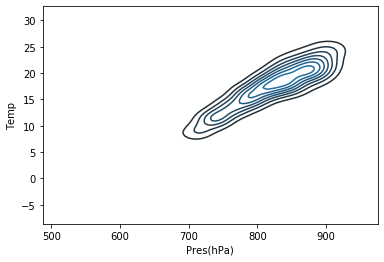

In [51]:
aa=result[(abs(result['real']-result['predict'])>2.2) ]
sns.kdeplot(aa['Pres']/100,aa['Temp']-273.55)
plt.xlabel('Pres(hPa)')


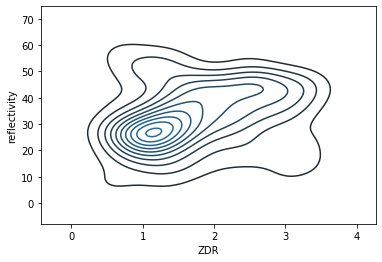

In [21]:
aa=result[(abs(result['real']-result['predict'])>0.2) & (result['real']>0.98)]
sns.kdeplot(aa['ZDR'],aa['reflectivity'])
#plt.xlabel('Pres(hPa)')

In [62]:
result[(abs(result['real']-result['predict'])>2.2) ].head(30) #.count() #].count() # & (result['real']>0.90)].count()
#sns.distplot(why['Temp'],kde=True) #

,reflectivity,ZDR,KDP,rhv,Temp,Pres,real,predict
1736576,39.247375,3.083219,5.323238,0.991674,286.999054,76366.171875,4.559513,7.340156
2482752,28.307697,2.395306,3.101804,0.994250,285.438416,74532.054688,6.202399,9.602643
1329221,43.857780,3.343329,6.654810,0.994124,293.796631,86944.421875,15.484540,12.297538
1687229,37.130630,2.525926,4.693550,0.994207,290.120392,81617.835938,13.815431,11.031066
990246,27.156122,2.892642,3.023415,0.994250,295.703125,88104.382812,8.250859,12.294611
2248602,21.332855,1.419717,2.068854,0.981180,282.741608,71860.101562,3.804164,6.228903
1347722,47.682129,3.284764,7.917708,0.994207,291.679474,85313.156250,15.492320,13.000889
652201,34.669273,2.677614,4.226428,0.994250,293.256531,87937.453125,8.466778,12.322855
2222250,36.281277,1.886709,4.315434,0.993656,286.539978,77362.179688,7.691005,11.386958
1671710,28.766273,0.911645,2.696353,0.994250,289.833984,82045.656250,9.320242,13.822813


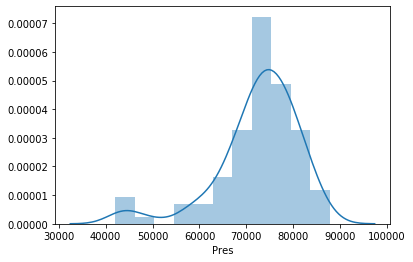

In [136]:
sns.distplot(why['Pres'],kde=True)

Text(0, 0.5, 'Predict')

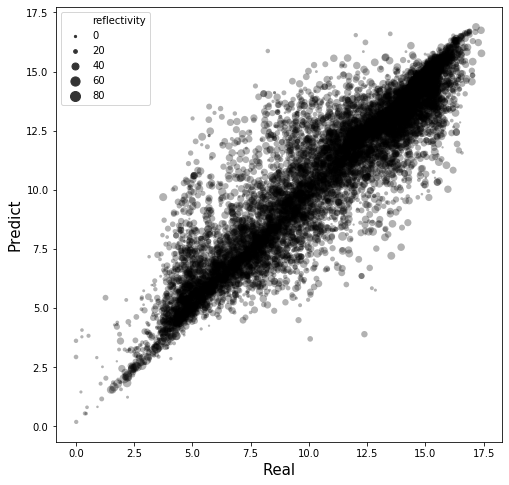

In [32]:
plt.figure(figsize=(8,8))
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot('real','predict',size='reflectivity',data=result,sizes=(5, 100),palette="coolwarm",color='black',linewidth=0,alpha=0.3) #,edgecolors='red')
plt.xlabel('Real',fontsize=15)
plt.ylabel('Predict',fontsize=15)
#plt.ylim((0.5,1))

In [28]:
from sklearn.tree import DecisionTreeRegressor

In [46]:
dtree=DecisionTreeRegressor()
dtree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [48]:
y_dtree = dtree.predict(X_test)

In [29]:
from sklearn.metrics import mean_squared_error

In [32]:
import graphviz
from sklearn.tree import export_graphviz

In [49]:
#dot_data = export_graphviz(dtree, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("iris") 

In [30]:
print(mean_squared_error(y_test,y_pred))

2.221074550266799


In [31]:
print(mean_squared_error(y_test,y_dtree))

NameError: name 'y_dtree' is not defined